In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\yasho\Downloads\Trust_Safety _Conetnt\Dataset\Updated_Trust_Safety_Content_Dataset.csv")

In [3]:
df.shape

(100000, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   content_type            100000 non-null  object 
 1   engagement_score        100000 non-null  float64
 2   uploader_id             100000 non-null  object 
 3   content_id              100000 non-null  object 
 4   known_policy_violation  100000 non-null  int64  
 5   upload_channel          100000 non-null  object 
 6   device_type             100000 non-null  object 
 7   toxicity_score          100000 non-null  float64
 8   misleading_title_flag   100000 non-null  int64  
 9   age_sensitivity_flag    100000 non-null  int64  
 10  policy_violation_risk   100000 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 8.4+ MB


In [5]:
df.isnull().sum()

content_type              0
engagement_score          0
uploader_id               0
content_id                0
known_policy_violation    0
upload_channel            0
device_type               0
toxicity_score            0
misleading_title_flag     0
age_sensitivity_flag      0
policy_violation_risk     0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
# Convert flags to binary
df['misleading_title_flag'] = df['misleading_title_flag'].astype(int)
df['age_sensitivity_flag'] = df['age_sensitivity_flag'].astype(int)



# Optional: Create user behavior features
df['uploader_violation_rate'] = df.groupby('uploader_id')['known_policy_violation'].transform('mean')


In [8]:
df['toxicity_engagement_interaction'] = df['toxicity_score'] * df['engagement_score']
df['sensitive_toxic_combo'] = df['toxicity_score'] * df['age_sensitivity_flag']
df['misleading_toxic_combo'] = df['toxicity_score'] * df['misleading_title_flag']


In [9]:
# Violation rate per uploader
df['uploader_violation_rate'] = df.groupby('uploader_id')['known_policy_violation'].transform('mean')

# Total uploads by uploader
df['uploader_total_uploads'] = df.groupby('uploader_id')['content_id'].transform('count')

# Upload ratio of flagged content
df['uploader_flag_ratio'] = (
    df.groupby('uploader_id')['misleading_title_flag'].transform('sum') /
    df['uploader_total_uploads']
).fillna(0)


In [10]:
# Mean toxicity per content type
df['avg_toxicity_by_type'] = df.groupby('content_type')['toxicity_score'].transform('mean')

# Content's toxicity vs type average
df['toxicity_diff_type_avg'] = df['toxicity_score'] - df['avg_toxicity_by_type']


In [11]:
df['high_toxicity_flag'] = (df['toxicity_score'] > 0.75).astype(int)
df['low_engagement_flag'] = (df['engagement_score'] < 10).astype(int)
df['risky_combination_flag'] = (
    (df['high_toxicity_flag'] & df['misleading_title_flag']) |
    (df['age_sensitivity_flag'] & df['low_engagement_flag'])
).astype(int)


In [12]:
# Device diversity per uploader
device_diversity = df.groupby('uploader_id')['device_type'].nunique()
df['uploader_device_diversity'] = df['uploader_id'].map(device_diversity)

# Content diversity
content_diversity = df.groupby('uploader_id')['content_type'].nunique()
df['uploader_content_diversity'] = df['uploader_id'].map(content_diversity)


In [13]:
df.shape

(100000, 24)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   content_type                     100000 non-null  object 
 1   engagement_score                 100000 non-null  float64
 2   uploader_id                      100000 non-null  object 
 3   content_id                       100000 non-null  object 
 4   known_policy_violation           100000 non-null  int64  
 5   upload_channel                   100000 non-null  object 
 6   device_type                      100000 non-null  object 
 7   toxicity_score                   100000 non-null  float64
 8   misleading_title_flag            100000 non-null  int32  
 9   age_sensitivity_flag             100000 non-null  int32  
 10  policy_violation_risk            100000 non-null  float64
 11  uploader_violation_rate          100000 non-null  float64
 12  tox

In [15]:
# One-hot encoding categorical features
df = pd.get_dummies(df, columns=['content_type', 'upload_channel', 'device_type'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   engagement_score                 100000 non-null  float64
 1   uploader_id                      100000 non-null  object 
 2   content_id                       100000 non-null  object 
 3   known_policy_violation           100000 non-null  int64  
 4   toxicity_score                   100000 non-null  float64
 5   misleading_title_flag            100000 non-null  int32  
 6   age_sensitivity_flag             100000 non-null  int32  
 7   policy_violation_risk            100000 non-null  float64
 8   uploader_violation_rate          100000 non-null  float64
 9   toxicity_engagement_interaction  100000 non-null  float64
 10  sensitive_toxic_combo            100000 non-null  float64
 11  misleading_toxic_combo           100000 non-null  float64
 12  upl

In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(['content_id', 'uploader_id', 'known_policy_violation', 'policy_violation_risk'], axis=1)
y = df['known_policy_violation']  # Binary target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [35]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19993
           1       1.00      1.00      1.00         7

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

ROC-AUC Score: 1.0


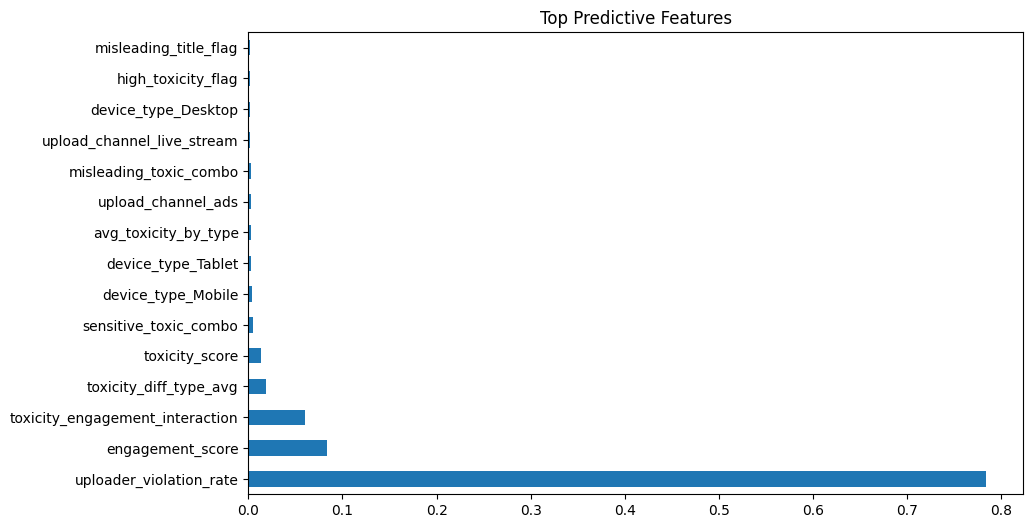

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(10,6))
plt.title("Top Predictive Features")
plt.show()


In [41]:
df['predicted_violation_score'] = model.predict_proba(X)[:,1]


In [43]:
# Assign risk categories
def risk_category(score):
    if score >= 0.8:
        return 'High'
    elif score >= 0.5:
        return 'Medium'
    else:
        return 'Low'

df['risk_level'] = df['predicted_violation_score'].apply(risk_category)


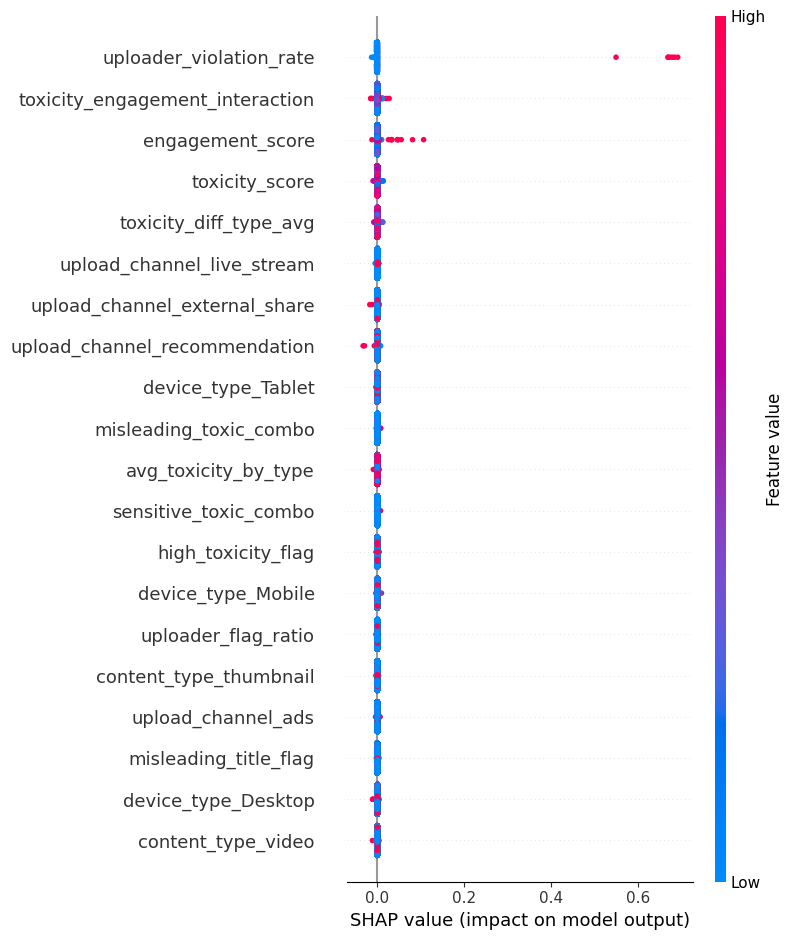

In [45]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)


In [47]:
import joblib

joblib.dump(model, "policy_violation_model.pkl")


['policy_violation_model.pkl']